In [462]:
# general 
import pandas as pd 
import numpy as np 
import pickle
import math

import pyarrow as pa
import pyarrow.parquet as pq

# stats
from scipy import stats
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

# tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import pacf, acf

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)
pd.options.plotting.backend = "plotly"

# ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# darts
from darts import TimeSeries

In [23]:
# load all dataframes
cgm_df = pd.read_parquet("Parquet Files/cgm_df.parquet.gzip")

In [24]:
cgm_df.head()

,glucose
datetime,
2022-03-08 11:57:00,4.400000
2022-03-08 11:57:01,4.408333
2022-03-08 11:57:02,4.416667
2022-03-08 11:57:03,4.425000
2022-03-08 11:57:04,4.433333


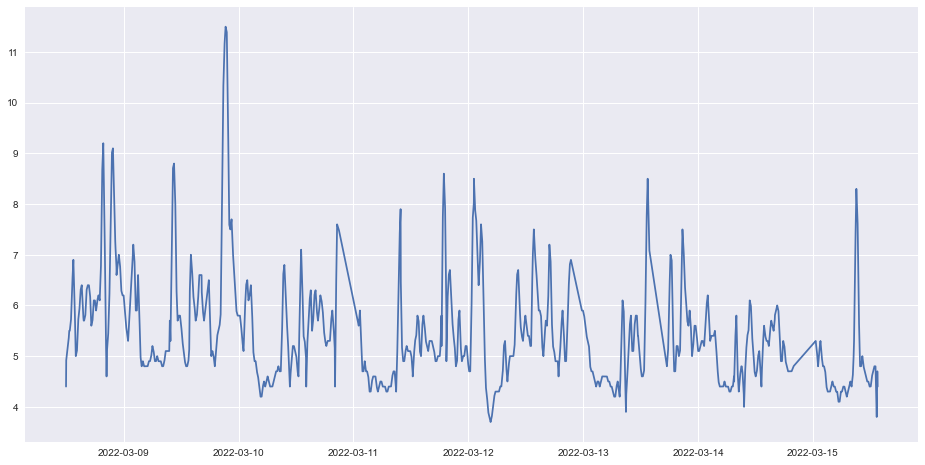

In [25]:
plt.plot(cgm_df)

In [26]:
cgm_df.describe()

,glucose
count,610441.000000
mean,5.490189
std,1.028178
min,3.700000
25%,4.791111
50%,5.256778
75%,5.974000
max,11.500000


In [27]:
daily_cgm_list = [group for name, group in cgm_df.groupby(pd.Grouper(freq="D"))]

In [28]:
# print first datetime and last datetime for all 8 days
def start_end_index(df):
    print(pd.DataFrame(
        {"Start Time": [day.index[0] for day in df],
        "End Time": [day.index[-1] for day in df]
        },
        index=[day for day in range(len(df))]
    ))

In [29]:
start_end_index(daily_cgm_list)

           Start Time            End Time
0 2022-03-08 11:57:00 2022-03-08 23:59:59
1 2022-03-09 00:00:00 2022-03-09 23:59:59
2 2022-03-10 00:00:00 2022-03-10 23:59:59
3 2022-03-11 00:00:00 2022-03-11 23:59:59
4 2022-03-12 00:00:00 2022-03-12 23:59:59
5 2022-03-13 00:00:00 2022-03-13 23:59:59
6 2022-03-14 00:00:00 2022-03-14 23:59:59
7 2022-03-15 00:00:00 2022-03-15 13:31:00


On day 1, cgm starts at 1157, on day 8, cgm ends at 1331. Drop both from list.

In [30]:
# concat all cgm values
full_day_cgm = pd.concat(daily_cgm_list[1:-1])

In [31]:
# resample and get minute values
full_day_min_cgm = full_day_cgm.resample('5T').median()

In [32]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    return {"rmse" : rmse,
            "mae": mae,
            "mse": mse,
            "mape": mape,
            "r2": r2}

In [33]:
# using sktime's naive forecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split

import warnings
warnings.filterwarnings("ignore")

Mean RMSE for naive forecast: 0.9695923738036054.


0.9695923738036054

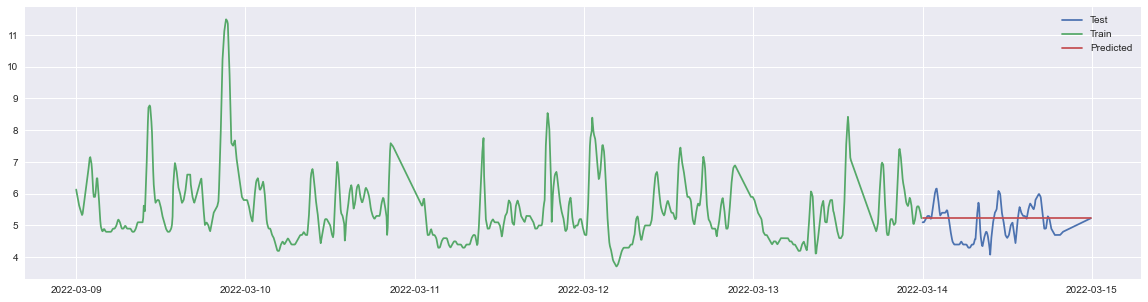

In [34]:
def naive_walk(data):
    count = 0
    errors = []
    data = data.reset_index()
    timeSeriesCrossVal = TimeSeriesSplit(n_splits=5) # no. splits = no. of days - 1
    
    # iterate through dataframe
    for train_lst, test_lst in timeSeriesCrossVal.split(data):
        
        # get train and test sets
        y_train = data.iloc[train_lst[0]:train_lst[-1]]
        y_test = data.iloc[test_lst[0]:test_lst[-1]]
        
        # fit
        forecaster = NaiveForecaster(strategy="last")
        forecaster.fit(y_train)
        
        # predict
        y_pred = forecaster.predict(test_lst[:-1])
        
        # compute errors
        err = timeseries_evaluation_metrics_func(y_test['glucose'].values,
                                                 y_pred['glucose'].values)
        errors.append(err['rmse'])
        
        # if last split, get the values for plotting
        count = count+1
        if count == 5:
            fig, ax = plt.subplots(figsize=(20, 5))
            ax.plot(y_test.set_index("datetime"), label="Test")
            ax.plot(y_train.set_index("datetime"), label="Train")
            ax.plot(pd.Series(y_pred['glucose'].values, index=y_test['datetime']), label="Predicted")
            ax.legend(loc='best')
            fig.show()

    mean_rmse = np.mean(errors)
    
    print(f"Mean RMSE for naive forecast: {mean_rmse}.")
    return mean_rmse
        
naive_walk(full_day_min_cgm['glucose'])

With naive forecast done, proceed to classical models:
- Pure ARIMA for glucose
- ARIMAX with HRV exogenous variables
- VARMA with HRV exogenous variables

For the remainder of the methods, only a simple time series split will be performed, so as to lessen computation time.

Training set shape: (1439, 1)
Test set shape: (289, 1)


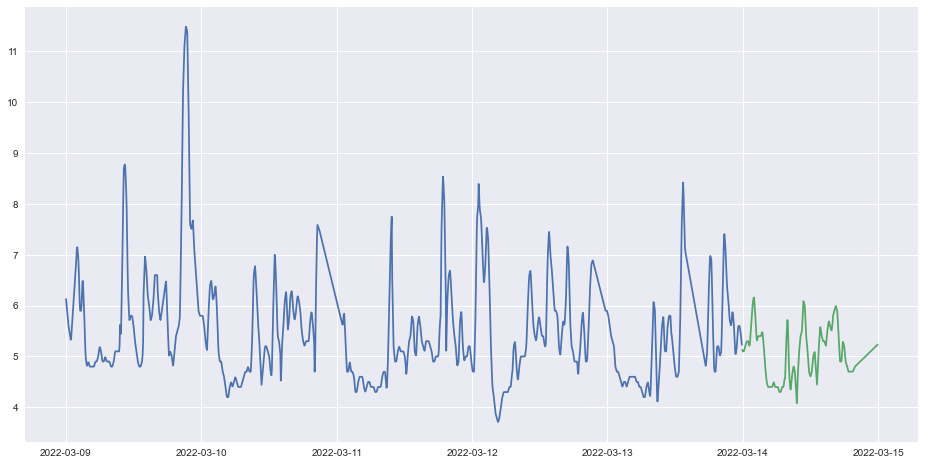

In [35]:
# 25% of the dataset will be used for validation
train, val = temporal_train_test_split(full_day_min_cgm, test_size=0.16666667)
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {val.shape}")
plt.plot(train, label="training")
plt.plot(val, label="validation")

In [45]:
# diff and log the time series
train['log glucose'] = np.log(train['glucose'])
train['difflog glucose'] = train['log glucose'].diff().fillna(0)
train.head()

,glucose,log glucose,difflog glucose
datetime,,,
2022-03-09 00:00:00,6.130167,1.813222,0.000000
2022-03-09 00:05:00,6.030167,1.796775,-0.016447
2022-03-09 00:10:00,5.930167,1.780052,-0.016722
2022-03-09 00:15:00,5.830167,1.763046,-0.017007
2022-03-09 00:20:00,5.730167,1.745745,-0.017301


In [36]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.\n")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.\n")

In [43]:
adfuller_test(train['glucose'], name="Glucose")

    Augmented Dickey-Fuller Test on "Glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7832
 No. Lags Chosen       = 13
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



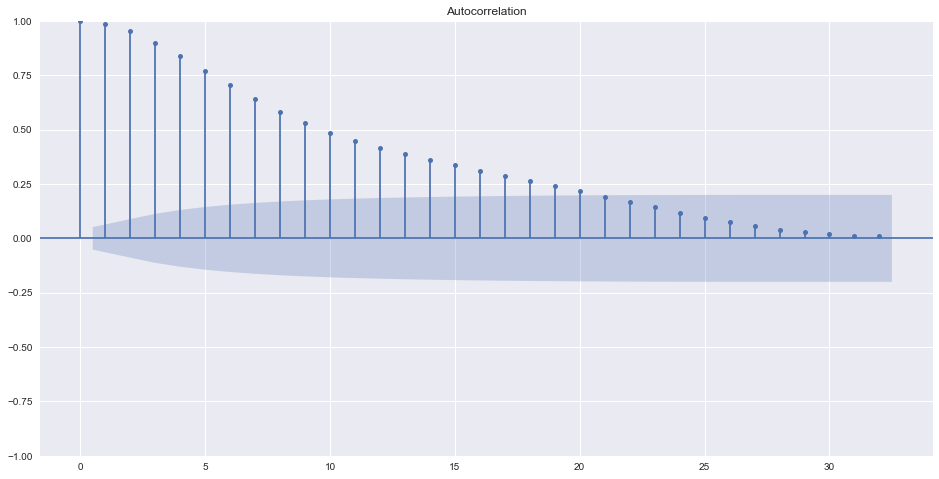

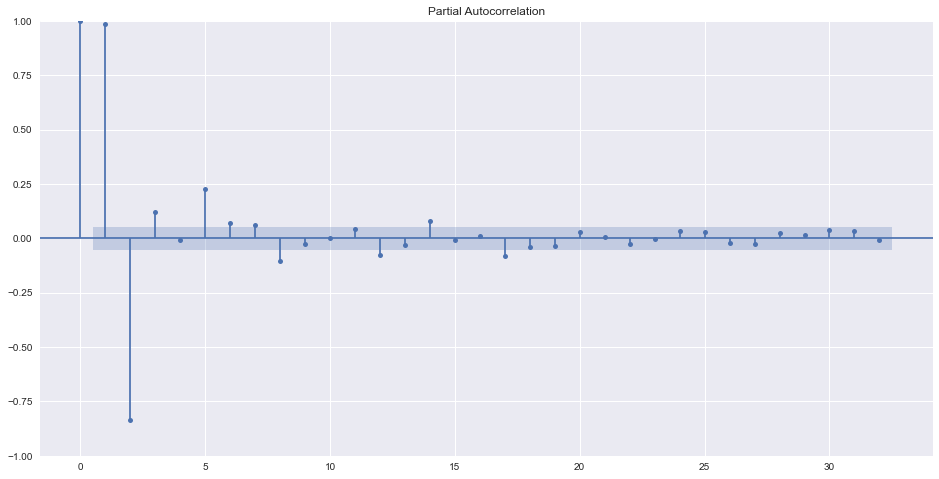

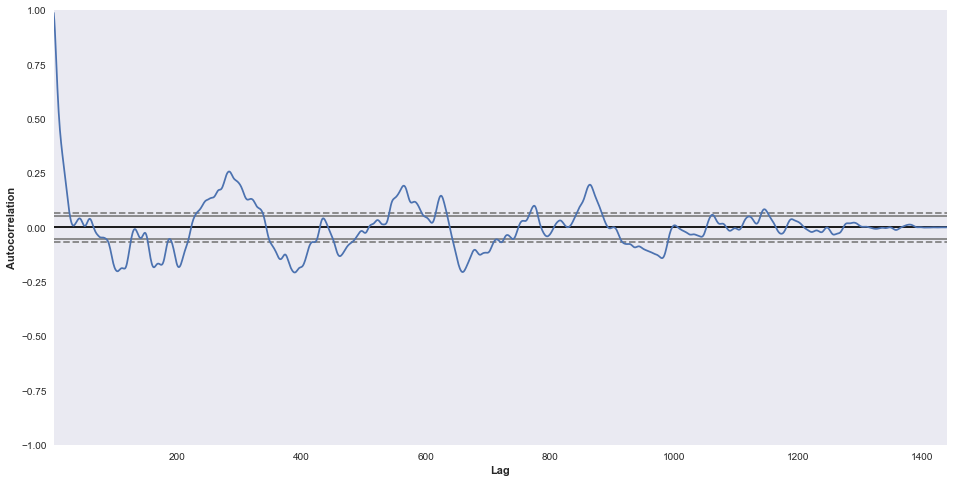

In [125]:
acf = plot_acf(train['glucose'], alpha=0.05)
pacf = plot_pacf(train['glucose'], alpha=0.05)
autocor = autocorr_plot(train['glucose'])

As seen, autocorrelation up til 19, and partial autocorrelation up to 5.

In [19]:
import pmdarima as pm

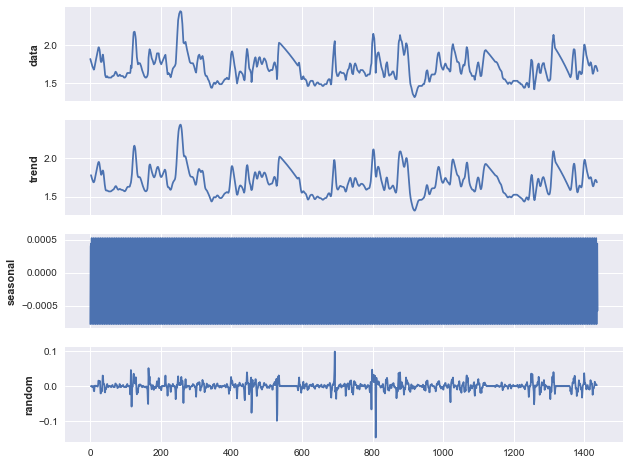

In [46]:
figure_kwargs = {'figsize': (10, 8)}
decomposed = pm.arima.decompose(train['log glucose'].values, 'additive', m=5)
axes = pm.utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,
                             show=False)

In [59]:
model = pm.auto_arima(train['glucose'],
                      trace=True,
                      max_p=5, max_q=20, max_order=25,
                      stepwise=True,
                      seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2433.262, Time=1.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4232.316, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-967.908, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2349.922, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9077.461, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2128.312, Time=1.91 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2435.243, Time=0.93 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1871.745, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-2436.228, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-2435.245, Time=0.57 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-2439.997, Time=2.00 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-2438.862, Time=2.19 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-2431.950, Time=2.31 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-2433.311, Time=0.49 sec
 ARIMA(4,0,2)(0,0,0)[0]

In [60]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1439
Model:               SARIMAX(3, 0, 1)   Log Likelihood                1225.999
Date:                Sun, 27 Mar 2022   AIC                          -2439.997
Time:                        15:56:44   BIC                          -2408.367
Sample:                             0   HQIC                         -2428.189
                               - 1439                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2326      0.037      6.285      0.000       0.160       0.305
ar.L1          1.0585      0.190      5.578      0.000       0.687       1.430
ar.L2          0.4578      0.342      1.340      0.180      -0.212       1.128
ar.L3         -0.5581      0.157     -3.558      0.000      -0.866      -0.251
ma.L1          0.7578      0.187      4.058      0.000       0.392       1.124
sigma2         0.0105      0.000     97.615      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):            151459.22
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
test_pred, confint = model.predict(n_periods=len(val), return_conf_int=True)
arima_rmse = timeseries_evaluation_metrics_func(val, test_pred)
print(f"Mean RMSE for ARIMA forecast: {arima_rmse['rmse']}.")

Mean RMSE for ARIMA forecast: 0.6773566366478448.


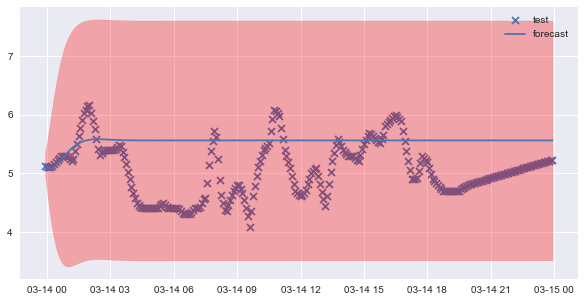

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(val.index, val['glucose'], marker='x', label='test')
ax.plot(val.index, test_pred, label='forecast')
ax.fill_between(val.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend()

Update ARIMA model with HRV params

In [356]:
# load all pickle files
with open('Pickle Files/all_list_pkl', 'rb') as f:
    daily_df_features = pickle.load(f)

In [357]:
daily_df_features[0].head()

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-08 12:01:54,1040.669173,148.236284,50.589232,79,29.811321,163,61.509434,50.590476,1040.5,652.0,...,81.967213,43.352601,8.821342,2711.279214,329.983011,8.216421,89.149801,10.850199,11987.700778,8946.438552
2022-03-08 12:01:55,1041.352060,148.377553,50.494850,79,29.699248,163,61.278195,50.496222,1041.0,652.0,...,81.967213,43.352601,8.825257,2711.279214,329.983011,8.216421,89.149801,10.850199,11987.700778,8946.438552
2022-03-08 12:01:56,1041.727612,148.226989,50.644712,80,29.962547,164,61.423221,50.644757,1043.5,652.0,...,81.967213,43.352601,8.817183,2711.279214,329.983011,8.216421,89.149801,10.850199,11987.700778,8946.438552
2022-03-08 12:01:57,1042.148699,148.111294,50.556287,80,29.850746,164,61.194030,50.556419,1046.0,652.0,...,81.967213,43.352601,8.810736,2711.279214,329.983011,8.216421,89.149801,10.850199,11987.700778,8946.438552
2022-03-08 12:01:58,1042.522222,147.963089,50.467615,80,29.739777,164,60.966543,50.467664,1046.0,652.0,...,81.967213,43.352601,8.802754,2711.279214,329.983011,8.216421,89.149801,10.850199,11987.700778,8946.438552


In [358]:
# for each day of readings, join the cgm values to hrv features
def join_glucose_and_features(glucose_df_list, feature_df_list, on, how):
    l = []
    for day, values in enumerate(glucose_df_list):
        all = pd.merge(left=glucose_df_list[day],
                       right=feature_df_list[day],
                       on=on,
                       how=how)
        l.append(all)
    return l

CGM monitors blood glucose 24/7. HRV is only measured from the morning to evenings. Use an inner join to only obtain points where there are measurements.

In [359]:
all_df = join_glucose_and_features(daily_cgm_list,
                                   daily_df_features,
                                   on="datetime",
                                   how="inner")

In [360]:
# print first datetime and last datetime for all 8 days
def start_end_index(df):
    print(pd.DataFrame(
        {"Start Time": [day.index[0] for day in df],
        "End Time": [day.index[-1] for day in df]
        },
        index=[day for day in range(len(df))]
    ))
    
start_end_index(all_df)

           Start Time            End Time
0 2022-03-08 12:01:54 2022-03-08 22:29:18
1 2022-03-09 09:46:36 2022-03-09 22:22:26
2 2022-03-10 08:50:56 2022-03-10 22:37:03
3 2022-03-11 08:59:57 2022-03-11 21:56:55
4 2022-03-12 07:26:25 2022-03-12 22:15:09
5 2022-03-13 09:04:52 2022-03-13 22:21:25
6 2022-03-14 09:27:05 2022-03-14 22:38:37
7 2022-03-15 08:31:22 2022-03-15 13:31:00


- Latest start time: 09:46:36 -> 09:50:00 (excluding day 1, to be dropped)
- Earliest end time: 21:56:55 -> 21:50:00 (excluding day 6, to be dropped)

Total: 12 hours of data

In [361]:
# truncate input days by latest start time and earliest 
# end time so that we can create multiple discrete sequences
trunc_all_df = [all_df[1].truncate(before=pd.Timestamp('2022-03-09 09:50:00'),
                                    after=pd.Timestamp('2022-03-09 21:50:00')),
                all_df[2].truncate(before=pd.Timestamp('2022-03-10 09:50:00'),
                                    after=pd.Timestamp('2022-03-10 21:50:00')),
                all_df[3].truncate(before=pd.Timestamp('2022-03-11 09:50:00'),
                                    after=pd.Timestamp('2022-03-11 21:50:00')),
                all_df[4].truncate(before=pd.Timestamp('2022-03-12 09:50:00'),
                                    after=pd.Timestamp('2022-03-12 21:50:00')),
                all_df[5].truncate(before=pd.Timestamp('2022-03-13 09:50:00'),
                                    after=pd.Timestamp('2022-03-13 21:50:00')),
                all_df[6].truncate(before=pd.Timestamp('2022-03-14 09:50:00'),
                                    after=pd.Timestamp('2022-03-14 21:50:00'))]

In [362]:
def resample_indiv_col(ls_of_df):
    l = []
    for i, v in enumerate(ls_of_df):
        d1 = ls_of_df[i].resample('5T').median()
        d1.interpolate(method='time', inplace=True)
        l.append(d1)
    return l

all_df_min = resample_indiv_col(trunc_all_df)

In [363]:
# flatten out entire list and truncate all dateframes
df = pd.concat(all_df_min)

In [364]:
df.tail()

,glucose,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,...,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-14 21:30:00,4.973981,1027.782759,106.971286,42.533090,68.0,23.693380,180.0,62.456140,42.533270,1056.00,...,80.106809,49.342105,6.661815,2154.636799,244.129390,9.332102,90.321427,9.678573,5969.263189,3369.977448
2022-03-14 21:35:00,4.982239,907.156385,155.320151,40.637671,48.0,14.779874,158.0,48.461524,40.640315,865.75,...,96.618357,48.000000,11.797848,2434.061463,216.861817,9.444985,90.426027,9.573973,9581.626361,6546.140882
2022-03-14 21:40:00,4.991502,1027.008591,83.042985,44.872243,66.0,22.916667,181.0,62.629758,44.872265,1045.00,...,74.626866,49.019608,4.905344,2936.688833,277.098395,10.466281,91.278773,8.721227,5190.040398,1978.246295
2022-03-14 21:45:00,5.000719,943.952681,100.754820,34.046375,36.0,11.635220,152.0,48.101266,34.048345,947.00,...,81.521739,49.019608,7.018106,1686.627123,182.496239,8.676224,89.665390,10.334610,3364.766792,1558.032671
2022-03-14 21:50:00,5.005036,854.638177,105.014081,29.898847,29.0,8.285714,155.0,44.285714,29.902699,841.00,...,92.592593,49.059689,8.407414,1488.921829,161.167104,9.238373,90.232823,9.767177,5915.893342,4265.804409


In [365]:
df.shape

(868, 24)

In [366]:
# no duplicates
df.index.duplicated().sum()

0

In [367]:
df.describe()

,glucose,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,...,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf
count,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,...,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000
mean,5.759154,1018.835662,120.282303,47.422032,62.159562,22.495257,159.601382,56.341294,47.427747,1031.025346,...,93.095906,48.249089,8.244915,2198.598468,363.904545,6.798427,84.620815,15.379185,7140.215289,4554.693191
std,1.039656,176.701724,43.996171,14.865238,28.646689,11.673469,34.188844,16.505100,14.865496,195.635855,...,63.403553,9.988057,4.461790,1321.887446,240.201693,3.345909,7.837728,7.837728,4194.039141,3315.970212
min,4.442222,369.770227,11.892507,4.280907,0.000000,0.000000,0.000000,0.000000,4.281221,365.000000,...,53.763441,27.919963,2.003231,1.407096,1.957896,0.435158,30.321269,3.054773,17.433777,13.619153
25%,5.083389,902.622779,89.213793,38.460353,43.000000,14.258441,153.000000,48.781920,38.465759,878.000000,...,75.000000,43.572985,5.522070,1315.949930,227.483275,4.554313,81.967558,10.602108,4135.009109,2054.251331
50%,5.503556,1047.892951,114.745798,47.164229,64.000000,22.886905,167.000000,61.130155,47.167527,1076.000000,...,83.449235,46.224961,7.508673,1999.954539,327.321875,6.204459,86.108404,13.891596,6364.742309,3718.473523
75%,6.114919,1157.432915,147.346431,56.541898,79.000000,30.129665,179.000000,67.628325,56.546476,1185.000000,...,94.674600,49.261084,10.296327,2782.706782,450.922235,8.445605,89.397892,18.032442,9323.284850,6223.276986
max,11.486778,1421.602871,291.140583,109.599513,244.000000,56.221198,292.000000,83.111111,109.600717,1437.000000,...,1276.595745,148.148148,66.331584,9726.105894,2947.730728,31.735653,96.945227,69.678731,25481.027371,22298.787147


In [368]:
# fn to check for NaNs and zeroes
def check_for_nans_zeroes(data):
    zero_count = [(data[col] == 0).sum() for col in data]
    NaN_count = [data[col].isnull().sum() for col in data]
    
    return pd.DataFrame(
    {'Number of Zeroes': zero_count, 'Number of Nans' : NaN_count},
    index=data.columns)
    
check_for_nans_zeroes(df)

,Number of Zeroes,Number of Nans
glucose,0,0
mean_nni,0,0
sdnn,0,0
sdsd,0,0
nni_50,10,0
pnni_50,10,0
nni_20,1,0
pnni_20,1,0
rmssd,0,0
median_nni,0,0


Stationarity checks with ADFuller

In [369]:
# run augmented dickey-fuller test on all columns to detect stationarity
def adf_harness(data):
    for colname, colvalues in data.iteritems():
        adfuller_test(colvalues, name=colname)
         
adf_harness(df)

    Augmented Dickey-Fuller Test on "glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1584
 No. Lags Chosen       = 5
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "mean_nni" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6742
 No. Lags Chosen       = 2
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "sdnn" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [370]:
fig = px.scatter(df)
fig.show()

Training set shape: (723, 24)
Test set shape: (145, 24)


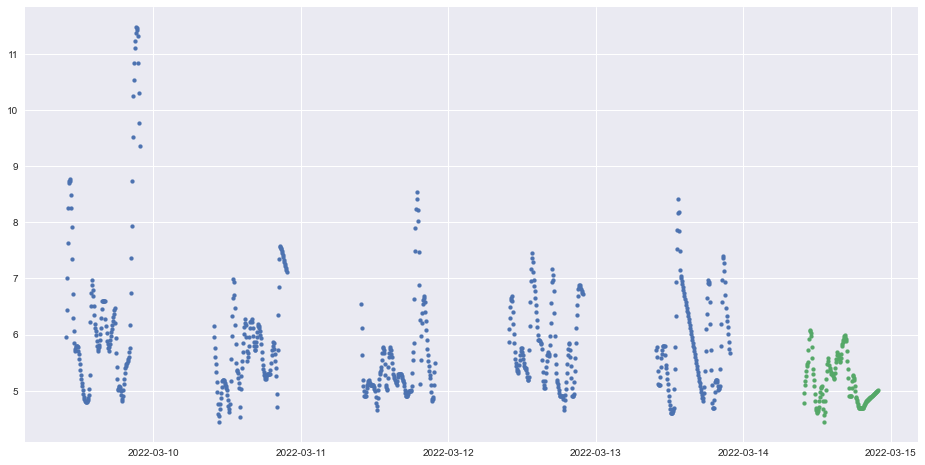

In [371]:
# split into train and test set
# final day of the dataset will be used for validation
train_all, val_all = temporal_train_test_split(df, test_size=0.16666667)
print(f"Training set shape: {train_all.shape}")
print(f"Test set shape: {val_all.shape}")

# plot
plt.scatter(y=train_all['glucose'], x=train_all.index, label="training", s=15)
plt.scatter(y=val_all['glucose'], x=val_all.index, label="validation", s=15)

In [372]:
from pmdarima.utils import plot_acf, plot_pacf, autocorr_plot

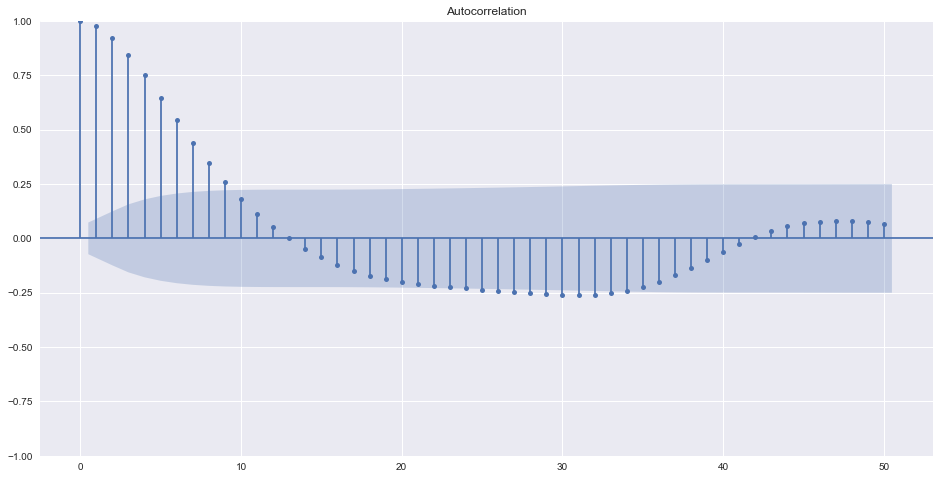

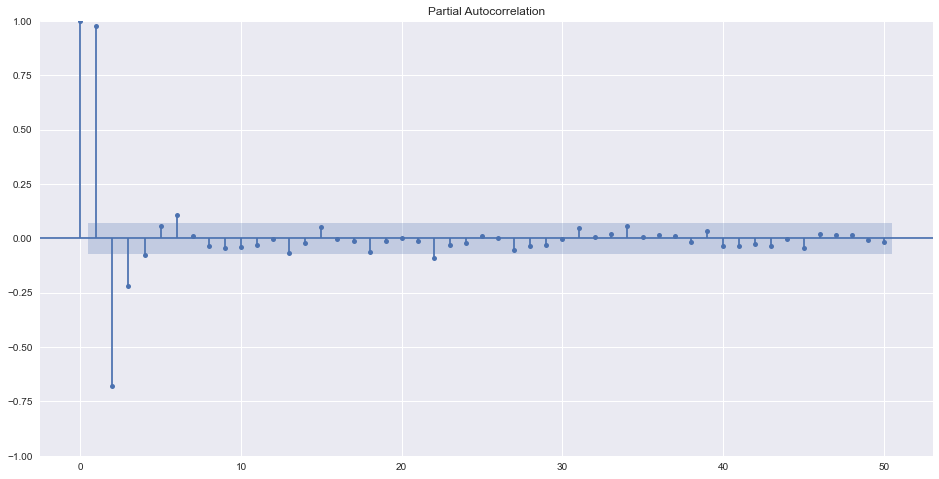

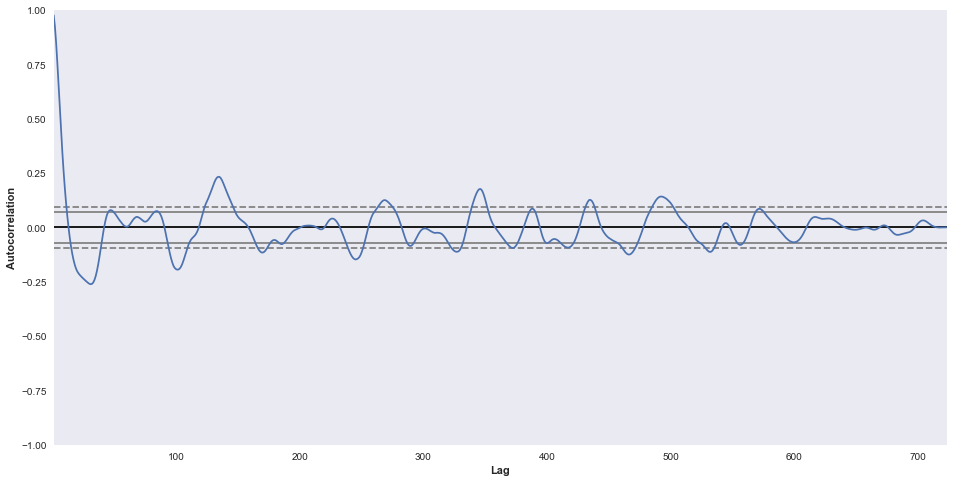

In [373]:
acf = plot_acf(train_all['glucose'], alpha=0.05, lags=50)
pacf = plot_pacf(train_all['glucose'], alpha=0.05, lags=50)
autocor = autocorr_plot(train_all['glucose'])

Possible params for p term: 8, q term: 3.

In [376]:
model = pm.auto_arima(y=train_all['glucose'],
                      x=train_all.drop('glucose', axis=1),
                      suppress_warnings=True,
                      seasonal=True,
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-450.314, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2173.610, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-27.205, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1300.323, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4639.460, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-328.094, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-450.038, Time=0.68 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-446.101, Time=2.04 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-456.156, Time=0.94 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-378.830, Time=0.97 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-455.188, Time=1.46 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-455.749, Time=1.03 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-422.616, Time=0.82 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-453.927, Time=0.94 sec
 ARIMA(2,0,3)(0,0,0)[0]           

In [377]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  723
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 235.078
Date:                Sun, 27 Mar 2022   AIC                           -456.156
Time:                        18:55:22   BIC                           -424.072
Sample:                             0   HQIC                          -443.772
                                - 723                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2556      0.042      6.142      0.000       0.174       0.337
ar.L1          1.7182      0.045     37.841      0.000       1.629       1.807
ar.L2         -0.7618      0.042    -18.124      0.000      -0.844      -0.679
ma.L1         -0.2979      0.056     -5.286      0.000      -0.408      -0.187
ma.L2          0.0792      0.038      2.104      0.035       0.005       0.153
ma.L3          0.1275      0.040      3.165      0.002       0.049       0.206
sigma2         0.0304      0.001     50.219      0.000       0.029       0.032
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            227061.38
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -3.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        89.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [378]:
test_pred, confint = model.predict(n_periods=len(val_all), return_conf_int=True)
arima_rmse = timeseries_evaluation_metrics_func(val_all['glucose'], test_pred)
print(f"Mean RMSE for ARIMA forecast: {arima_rmse['rmse']}.")

Mean RMSE for ARIMA forecast: 0.803440208466018.


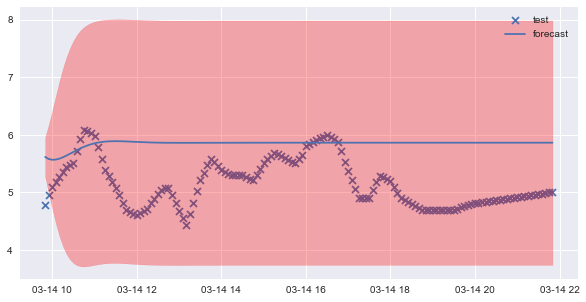

In [379]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(val_all.index, val_all['glucose'], marker='x', label='test')
ax.plot(val_all.index, test_pred, label='forecast')
ax.fill_between(val_all.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend()

### VARMA
Try out a VARMA model to attempt to forecast glucose from lagged regressors of HRV features.

Granger Casuality Test

Refer to:
>https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series

Granger casuality testing only applies to stationary intervals.

- Null hypothesis: HRV feature (x) does not explain variation in (y) glucose.
- Alternative hypothesis: HRV feature (x) has an effect on glucose with a 95% confidence interval that a change in x causes a response in 'glucose' (y)

In [380]:
# running a chi^2 test on each column of the df
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=12):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [458]:
grangers_causation_matrix(df, variables=df.columns)

,glucose_x,mean_nni_x,sdnn_x,sdsd_x,nni_50_x,pnni_50_x,nni_20_x,pnni_20_x,rmssd_x,median_nni_x,...,max_hr_x,min_hr_x,std_hr_x,lf_x,hf_x,lf_hf_ratio_x,lfnu_x,hfnu_x,total_power_x,vlf_x
glucose_y,1.0000,0.0037,0.0008,0.0010,0.0013,0.0008,0.0156,0.0027,0.0010,0.0044,...,0.2957,0.0019,0.1332,0.0624,0.0300,0.4575,0.0580,0.0580,0.0053,0.0082
mean_nni_y,0.6720,1.0000,0.0000,0.0913,0.4181,0.2647,0.0667,0.1924,0.0910,0.0096,...,0.2240,0.0000,0.0231,0.0011,0.1464,0.0009,0.0005,0.0005,0.0048,0.0082
sdnn_y,0.0403,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0002,0.0001,0.1356,0.0858,0.0858,0.0075,0.3901
sdsd_y,0.4551,0.0000,0.5363,1.0000,0.0001,0.0000,0.6119,0.0002,0.0070,0.0000,...,0.0003,0.0083,0.0000,0.0077,0.0000,0.4089,0.0727,0.0727,0.2194,0.3745
nni_50_y,0.0329,0.0000,0.6752,0.1403,1.0000,0.0000,0.1459,0.0032,0.1400,0.0000,...,0.0000,0.0224,0.0000,0.0632,0.0004,0.5957,0.1332,0.1332,0.5569,0.5743
pnni_50_y,0.1981,0.0003,0.0611,0.6844,0.0016,1.0000,0.2781,0.1212,0.6840,0.0004,...,0.0058,0.0031,0.0591,0.0166,0.0012,0.2204,0.0424,0.0424,0.5582,0.5151
nni_20_y,0.1232,0.0000,0.3850,0.2285,0.0171,0.0127,1.0000,0.0000,0.2280,0.0000,...,0.0000,0.0000,0.0000,0.1122,0.0562,0.0777,0.0007,0.0007,0.3616,0.2969
pnni_20_y,0.5931,0.0002,0.0062,0.5726,0.0633,0.1647,0.0511,1.0000,0.5712,0.0041,...,0.0008,0.0000,0.0539,0.1731,0.1055,0.0040,0.0007,0.0007,0.2097,0.1140
rmssd_y,0.4551,0.0000,0.5386,0.0072,0.0001,0.0000,0.6131,0.0002,1.0000,0.0000,...,0.0003,0.0084,0.0000,0.0077,0.0000,0.4080,0.0725,0.0725,0.2192,0.3745
median_nni_y,0.7521,0.0000,0.0009,0.0248,0.2266,0.1577,0.0097,0.0007,0.0247,1.0000,...,0.0438,0.0000,0.6876,0.0044,0.1308,0.0025,0.0008,0.0008,0.0632,0.1617


In [454]:
def cointegration_test(data, alpha=0.05):
    out = coint_johansen(data, -1, 10)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [460]:
# time domain attributes
cointegration_test(\
    df[['glucose', 'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20',
       'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
glucose ::  862.98    > nan       =>   False
mean_nni ::  722.34    > 311.1288  =>   True
sdnn   ::  599.72    > 263.2603  =>   True
sdsd   ::  495.18    > 219.4051  =>   True
nni_50 ::  400.31    > 179.5199  =>   True
pnni_50 ::  321.38    > 143.6691  =>   True
nni_20 ::  254.86    > 111.7797  =>   True
pnni_20 ::  190.59    > 83.9383   =>   True
rmssd  ::  136.79    > 60.0627   =>   True
median_nni ::  89.3      > 40.1749   =>   True
range_nni ::  51.56     > 24.2761   =>   True
cvsd   ::  20.5      > 12.3212   =>   True
cvnni  ::  0.04      > 4.1296    =>   False


In [461]:
# frequency domain attributes (without hfnu)
cointegration_test(\
    df[['glucose', 'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio',
       'lfnu', 'total_power', 'vlf']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
glucose ::  723.01    > 263.2603  =>   True
mean_hr ::  580.79    > 219.4051  =>   True
max_hr ::  454.72    > 179.5199  =>   True
min_hr ::  369.05    > 143.6691  =>   True
std_hr ::  286.33    > 111.7797  =>   True
lf     ::  220.47    > 83.9383   =>   True
hf     ::  158.66    > 60.0627   =>   True
lf_hf_ratio ::  106.93    > 40.1749   =>   True
lfnu   ::  56.34     > 24.2761   =>   True
total_power ::  21.92     > 12.3212   =>   True
vlf    ::  0.01      > 4.1296    =>   False


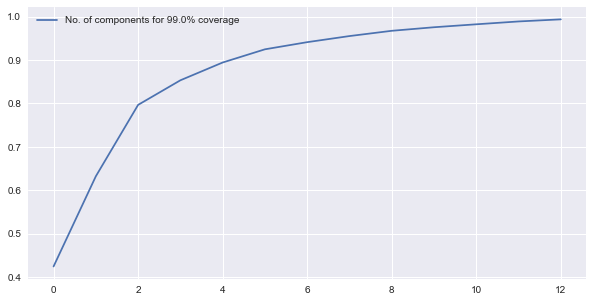

In [528]:
min_component_threshold = 0.99 # for 99% of feature coverage

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=min_component_threshold))
])

pipe = pipe.fit(train_all)

# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.cumsum(pipe.steps[1][1].explained_variance_ratio_), label=f"No. of components for \
{min_component_threshold*100}% coverage")
ax.legend()

In [531]:
def get_impt_features(fitted_pipe):
    """Returns a list of best features to perform VARMA"""
    pca_output = pipe.steps[1][1]
    
    # get no. of important components
    n_pcs= pca_output.n_components_

    # get index of important cols
    most_important = [np.abs(pca_output.components_[i]).argmax() for i in range(n_pcs)]

    # get names
    initial_feature_names = df.columns

    # get the most important feature names
    return [initial_feature_names[most_important[i]] for i in range(n_pcs)]

best_features = get_impt_features(pipe)
print(f"The best features are: {best_features}")

The best features are: ['rmssd', 'std_hr', 'hfnu', 'lf', 'glucose', 'vlf', 'hf', 'nni_20', 'max_hr', 'lf_hf_ratio', 'lf', 'hf', 'range_nni']


#### Interpreting time series correlation
Refer to:
>https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series

Granger casuality testing only applies to stationary intervals.

- Null hypothesis: HRV feature (x) does not explain variation in (y) glucose.
- Alternative hypothesis: HRV feature (x) has an effect on glucose with a 95% confidence interval that a change in x causes a response in 'glucose' (y)

In [ ]:
# running a chi^2 test on each column of the df
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=12):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
grangers_causation_matrix(y_train_log_diff, variables=y_train_log_diff.columns)

In [ ]:
y_train_log_diff.info()

Glucose forecasts using ARIMA

Using a library, DARTS for TS forecasting

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train_log_diff['glucose'].values, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
model = VAR(y_train_log_diff[['glucose', 'rmssd']])
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

In [ ]:
## Cointegration test:

To find out how many lagging terms are required for a TS to become stationary.
With two or more TS, they are considered cointegrated if they have a statistically significant relationship.
This means, there exists a linear combination of them that has an order of integration less than that of the individual series.

- https://en.wikipedia.org/wiki/Cointegration
- http://www-stat.wharton.upenn.edu/~steele/Courses/434/434Context/Co-integration/Murray93DrunkAndDog.pdf
- https://en.m.wikipedia.org/wiki/Johansen_test
- https://en.wikipedia.org/wiki/Error_correction_model

null hypothesis: no cointegrating equations, alternate hypothesis: at least 1 cointegrating relationship

In [ ]:
def cointegration_test(data, alpha=0.05):
    out = coint_johansen(data, -1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        
cointegration_test(y_train_log_diff[['glucose', 'rmssd', 'sdnn', 'cvnni', 'lf', 'hf']])

In [ ]:
cointegration_test(y_train_log_diff[['glucose', 'rmssd', 'sdnn', 'cvnni', 'lf', 'hf']])